In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

from sklearn.decomposition import PCA

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

In [2]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/npd_sumstats/data"
beta_df_filename = f"{data_dir}/beta_df.pkl"
prec_df_filename = f"{data_dir}/prec_df.pkl"
beta_df = pd.read_pickle(beta_df_filename)
prec_df = pd.read_pickle(prec_df_filename)

trait_df = pd.read_csv(f"{data_dir}/../trait_meta.csv")
phenotype_dict = trait_df.set_index('ID')['Broad'].to_dict()

In [3]:
prec_df

,AD_sumstats_Jansenetal_2019sept.txt.gz,CNCR_Insomnia_all,ENIGMA_Intracraneal_Volume,IGAP_Alzheimer,Jones_et_al_2016_Chronotype,Jones_et_al_2016_SleepDuration,MDD_MHQ_BIP_METACARPA_INFO6_A5_NTOT_no23andMe_...,MDD_MHQ_METACARPA_INFO6_A5_NTOT_no23andMe_noUK...,MHQ_Depression_WG_MAF1_INFO4_HRC_Only_Filtered...,MHQ_Recurrent_Depression_WG_MAF1_INFO4_HRC_Onl...,...,ieu-b-7,ieu-b-8,ieu-b-9,ocd_aug2017.txt.gz,pgc-bip2021-BDI.vcf.txt.gz,pgc-bip2021-BDII.vcf.txt.gz,pgc-bip2021-all.vcf.txt.gz,pgc.scz2,pgcAN2.2019-07.vcf.txt.gz,pts_all_freeze2_overall.txt.gz
rs1000031,199024.458358,10011.549996,2.477238e-07,3763.784862,55017.520527,52766.675941,19871.688626,15137.680215,4178.434135,2233.846318,...,1841.993774,0.000000,0.000000,807.076446,6718.624026,2311.390533,10000.000000,8138.365288,4890.214680,5486.968450
rs10003281,22856.567361,1133.556664,2.916697e-08,426.883410,6600.520046,6409.862295,0.000000,0.000000,0.000000,0.000000,...,191.303716,1576.918373,522.797852,97.449835,644.180474,161.454642,1067.965312,845.102207,0.000000,1413.307705
rs10004866,94890.527221,4762.875436,1.050357e-07,1707.533638,32754.999475,26882.772432,10813.491125,8764.504708,4277.851437,2319.393853,...,1525.878906,8202.157669,2721.710114,364.197891,2953.686200,935.199993,4328.254848,3567.647779,1957.866708,3018.959063
rs10005804,206618.921729,11038.416428,2.772408e-07,4056.959714,64813.392133,62392.035336,22005.212954,16849.615739,4356.932963,2312.149576,...,1940.654777,18483.485302,6281.554632,849.985975,7305.135510,2525.188758,11080.332410,8482.205957,5175.715543,6400.000000
rs10008644,158063.789343,9423.397217,2.006455e-07,3156.167151,0.000000,0.000000,17241.393373,13367.745330,4233.525731,2245.263569,...,2576.721894,14146.018514,4756.898670,644.180474,5569.169080,1923.668821,8899.964400,6520.330626,4109.138725,5029.928072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs9989571,109822.466125,5873.344524,1.306537e-07,1992.984694,34294.837603,33358.164945,13084.182758,10409.396364,4202.125496,2229.414304,...,1033.901635,8865.806572,3155.174433,460.498444,3763.784862,1284.670033,5327.934360,4466.580154,2657.030503,3585.643085
rs9991694,26573.400307,8329.000636,0.000000e+00,1293.928886,47722.448143,47156.411824,13735.270804,10913.880494,4290.808036,2277.055875,...,940.946216,0.000000,0.000000,241.867800,4385.772554,1587.276392,6830.134554,4867.463148,0.000000,3673.094582
rs9992763,211931.733184,11131.971604,2.753919e-07,3955.539733,59284.820099,62341.100863,22088.886002,16776.496482,4282.664471,2272.667529,...,3380.205516,18850.312674,6355.890127,835.310234,7305.135510,2576.721894,11317.338162,8693.444193,5327.934360,5827.166249
rs9993607,196102.424365,10190.293509,2.527398e-07,3628.973726,58820.325813,54083.448826,20554.484769,15755.657508,4319.394301,2297.117807,...,1810.774106,17119.565470,5724.715856,802.510252,6718.624026,2356.489773,10412.328197,8019.157989,5029.928072,5917.159763


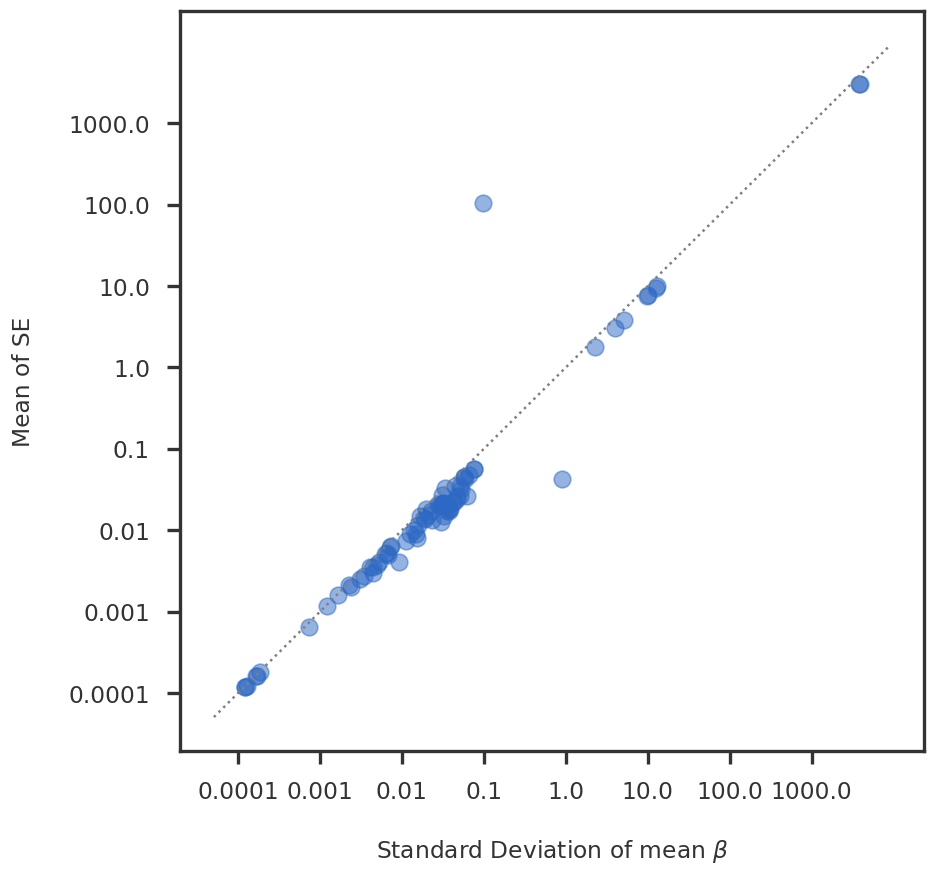

In [4]:
mean_se = prec_df.apply(lambda x : 1 / np.sqrt(x)).replace([np.inf, -np.inf], np.nan).mean(axis = 0, skipna = True)
mean_se = pd.DataFrame(mean_se).set_axis(["mean_se"], axis = 1)
beta_std = beta_df.std(axis = 0, skipna = True)
beta_std = pd.DataFrame(beta_std).set_axis(["beta_std"], axis = 1)
error_df = pd.concat([mean_se, beta_std], axis = 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.log10(error_df['beta_std']), np.log10(error_df['mean_se']), alpha = 0.5, s = 100)
mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log10')
mpl_utils.set_yticks(ax1, scale = 'log10', spacing = 'log10')
mpl_utils.plot_diag(ax1)
ax1.set_xlabel(r"Standard Deviation of mean $\beta$")
ax1.set_ylabel(r"Mean of SE")
plt.show()

In [5]:
select_ids = error_df.query("mean_se <= 0.05 & beta_std <= 0.05").index
#select_ids = error_df.index

# Simple PCA

In [7]:
X = np.array(beta_df[select_ids]).T
colmeans = np.mean(X, axis = 0, keepdims = True)
Xcent = X - colmeans

labels = [phenotype_dict[x] for x in select_ids]
unique_labels = list(set(labels))

In [8]:
ncomp = min(Xcent.shape)
pca = PCA(n_components = ncomp)
pca.fit(Xcent)
beta_pcs = pca.fit_transform(Xcent)
beta_eig  = pca.components_
beta_pcs.shape

(59, 59)

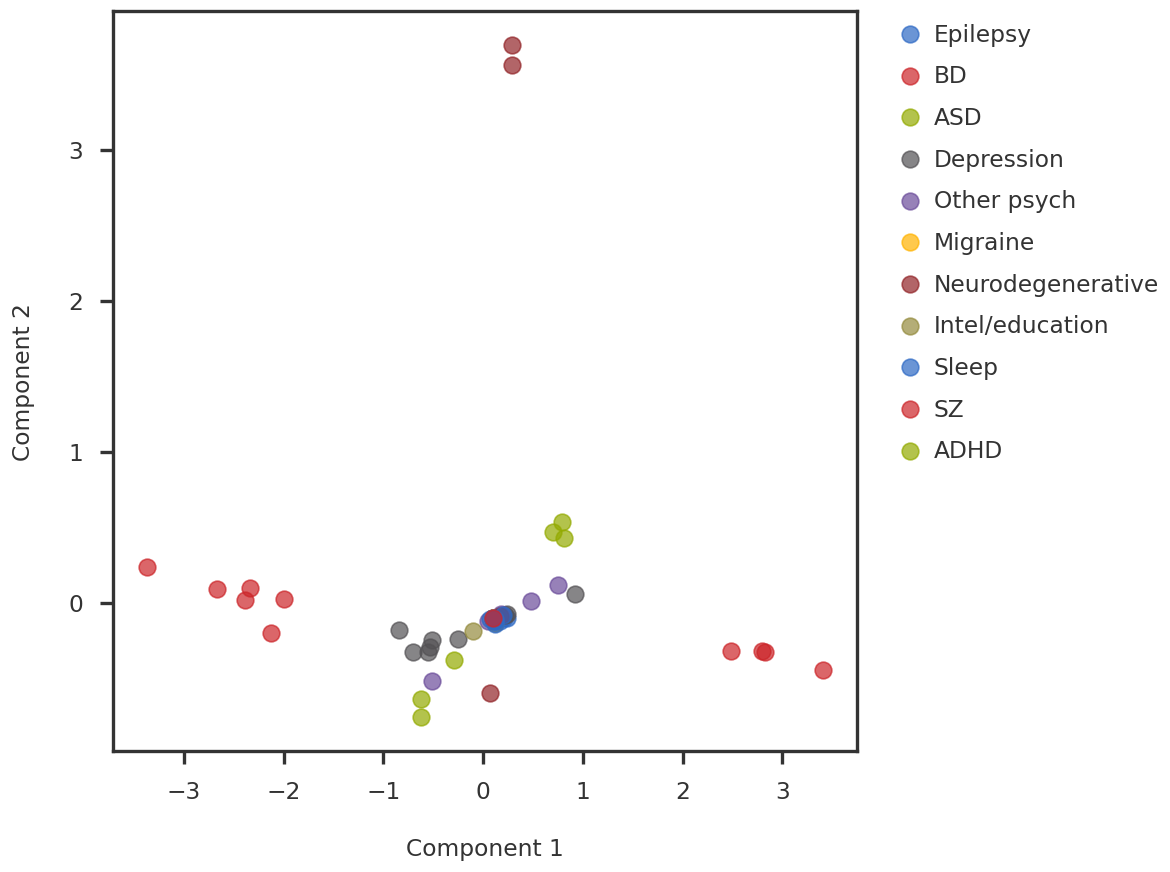

In [9]:
idx1 = 0
idx2 = 1

pc1 = beta_pcs[:, idx1]
pc2 = beta_pcs[:, idx2]

fig = plt.figure()
ax1 = fig.add_subplot(111)


for label in unique_labels:
    idx = np.array([i for i, x in enumerate(labels) if x == label])
    ax1.scatter(pc1[idx], pc2[idx], s = 100, alpha = 0.7, label = label)
    
ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax1.set_xlabel(f"Component {idx1 + 1}")
ax1.set_ylabel(f"Component {idx2 + 1}")
plt.show()

# Simple PCA using SVD

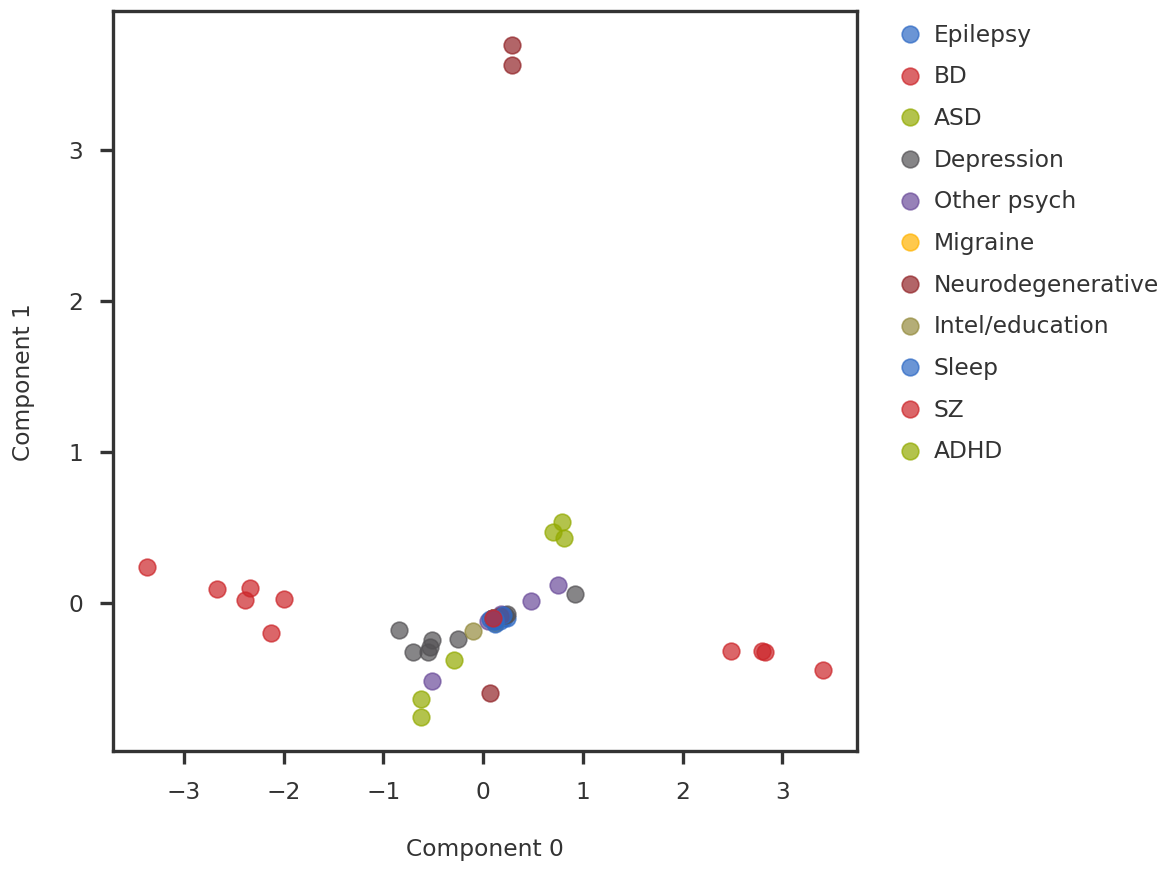

In [10]:
U, S, Vt = np.linalg.svd(Xcent, full_matrices=False)
svd_pcs = U @ np.diag(S)
svd_pc1 = svd_pcs[:, idx1]
svd_pc2 = svd_pcs[:, idx2]

fig = plt.figure()
ax1 = fig.add_subplot(111)

for label in unique_labels:
    idx = np.array([i for i, x in enumerate(labels) if x == label])
    ax1.scatter(svd_pc1[idx], svd_pc2[idx], s = 100, alpha = 0.7, label = label)
    
ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax1.set_xlabel(f"Component {idx1}")
ax1.set_ylabel(f"Component {idx2}")
plt.show()

# Weighted PCA

In [11]:
X.shape

(59, 8403)

In [12]:
W = np.array(prec_df[select_ids]).T

In [40]:
def weighted_mean(x, w=None, axis=None):
    """Compute the weighted mean along the given axis

    The result is equivalent to (x * w).sum(axis) / w.sum(axis),
    but large temporary arrays are not created.

    Parameters
    ----------
    x : array_like
        data for which mean is computed
    w : array_like (optional)
        weights corresponding to each data point. If supplied, it must be the
        same shape as x
    axis : int or None (optional)
        axis along which mean should be computed

    Returns
    -------
    mean : np.ndarray
        array representing the weighted mean along the given axis
    """
    if w is None:
        return np.mean(x, axis)

    x = np.asarray(x)
    w = np.asarray(w)

    if x.shape != w.shape:
        raise NotImplementedError("Broadcasting is not implemented: "
                                  "x and w must be the same shape.")

    if axis is None:
        wx_sum = np.einsum('i,i', np.ravel(x), np.ravel(w))
    else:
        try:
            axis = tuple(axis)
        except TypeError:
            axis = (axis,)

        if len(axis) != len(set(axis)):
            raise ValueError("duplicate value in 'axis'")

        trans = sorted(set(range(x.ndim)).difference(axis)) + list(axis)
        operand = "...{0},...{0}".format(''.join(chr(ord('i') + i)
                                                 for i in range(len(axis))))
        wx_sum = np.einsum(operand,
                           np.transpose(x, trans),
                           np.transpose(w, trans))

    return wx_sum / np.sum(w, axis)

def weighted_pca_components(X, W, n_components = None, regularization = None):
    
    import scipy as sp
    
    weights = weighted_mean(X, W, axis = 0).reshape(1, -1)
    _X = (X - weights) *  weights
    _covar = np.dot(_X.T, _X)
    _covar /= np.dot(weights.T, weights)
    _covar[np.isnan(_covar)] = 0

    n_components = 20
    eigvals = (_X.shape[1] - n_components, _X.shape[1] - 1)
    evals, evecs = sp.linalg.eigh(_covar, subset_by_index = eigvals)

    components = evecs[:, ::-1].T
    explained_variance = evals[::-1]
    Y = np.zeros((_X.shape[0], components.shape[0]))
    for i in range(_X.shape[0]):
        cW = components * weights[0, i]
        cWX = np.dot(cW, _X[i])
        cWc = np.dot(cW, cW.T)
        if regularization is not None:
            cWc += np.diag(regularization / explained_variance)
        Y[i] = np.linalg.solve(cWc, cWX)
    return Y

In [46]:
weighted_pcs = weighted_pca_components(X, W, n_components = 20, regularization = None)

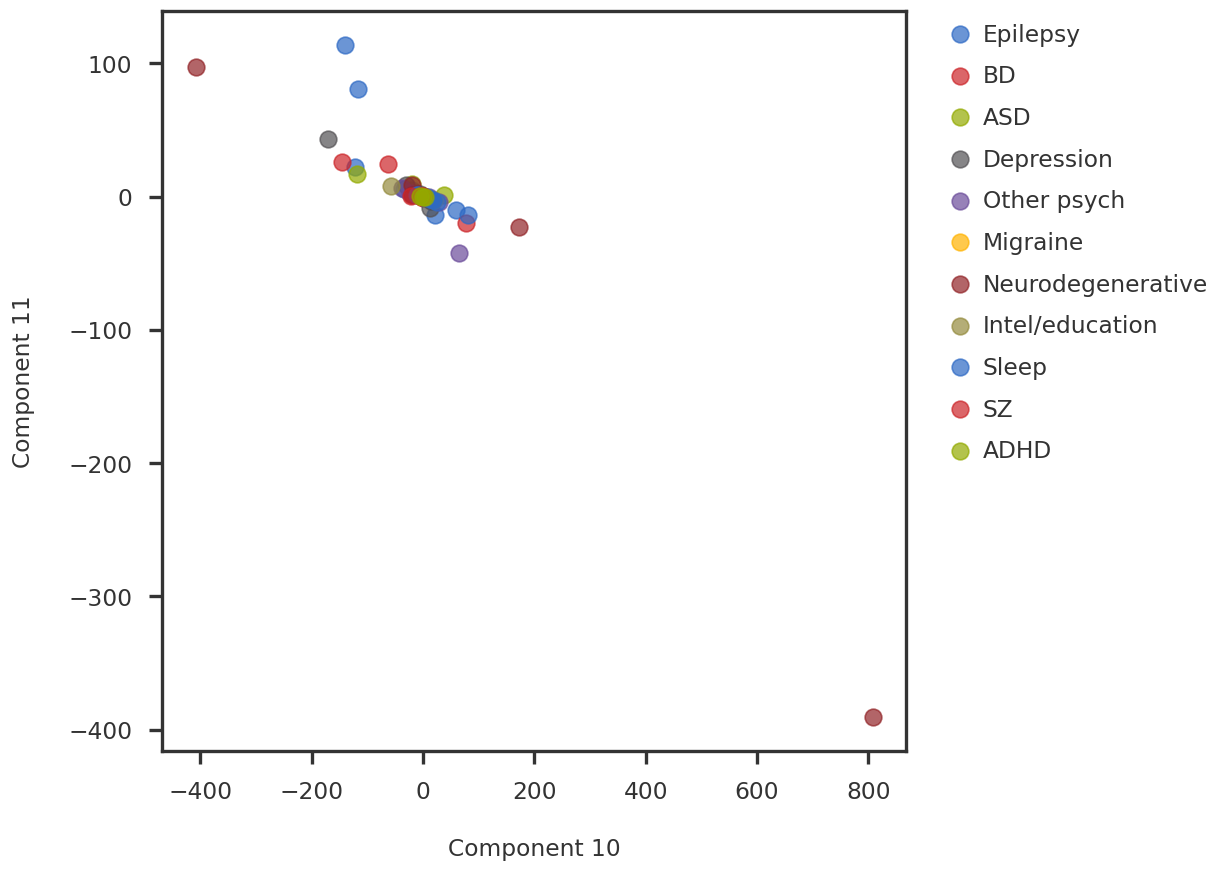

In [47]:
idx1 = 10
idx2 = 11

weighted_pc1 = weighted_pcs[:, idx1]
weighted_pc2 = weighted_pcs[:, idx2]

fig = plt.figure()
ax1 = fig.add_subplot(111)

for label in unique_labels:
    idx = np.array([i for i, x in enumerate(labels) if x == label])
    ax1.scatter(weighted_pc1[idx], weighted_pc2[idx], s = 100, alpha = 0.7, label = label)
    
ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax1.set_xlabel(f"Component {idx1}")
ax1.set_ylabel(f"Component {idx2}")
plt.show()

In [181]:
def weighted_pca_components(X, W, n_components = None):
    weights = weighted_mean(X, W, axis = 0).reshape(1, -1)
    _X = (X - weights) *  weights
    _covar = np.dot(_X.T, _X)
    _covar /= np.dot(weights.T, weights)
    _covar[np.isnan(_covar)] = 0

    
    eigvals = (_.shape[1] - n_components, X.shape[1] - 1)
        evals, evecs = linalg.eigh(covar, eigvals=eigvals)
        self.components_ = evecs[:, ::-1].T

(1, 8403)

In [182]:
X.shape

(59, 8403)